In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import shutil
import numpy as np
import glob
import random
import pandas as pd
import sklearn

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
fire_paths=[
    "/kaggle/input/fire-dataset-download/ds1/fire_dataset/fire_images/*",
    "/kaggle/input/fire-dataset-download/ds2/questal data set/Train/Fire/*",
    "/kaggle/input/fire-dataset-download/ds2/questal data set/Test/Fire/*",
    "/kaggle/input/fire-dataset-download/ds3/Fire-Detection/1/*",
    "/kaggle/input/fire-dataset-download/ds4/carlo/train/fire*",
    "/kaggle/input/fire-dataset-download/ds4/carlo/test/fire*"
]

neutral_paths=[
    "/kaggle/input/fire-dataset-download/ds1/fire_dataset/non_fire_images/*",
    "/kaggle/input/fire-dataset-download/ds3/Fire-Detection/0/*",
    "/kaggle/input/fire-dataset-download/ds2/questal data set/Train/Neutral/*",
    "/kaggle/input/fire-dataset-download/ds2/questal data set/Test/Neutral/*",
    "/kaggle/input/fire-dataset-download/ds4/carlo/train/not_fire*",
    "/kaggle/input/fire-dataset-download/ds4/carlo/test/not_fire*",
]


In [3]:
filepaths=[]
labels=[]
for path in fire_paths:
    for filepath in glob.glob(path):
        filepaths.append(filepath)
        labels.append(1)
for path in neutral_paths:
    for filepath in glob.glob(path):
        filepaths.append(filepath)
        labels.append(0)

In [4]:
X = [tf.keras.utils.img_to_array(tf.keras.utils.load_img(path,target_size=(150,150))) for path in filepaths]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(labels), test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1) 

In [6]:
from tensorflow.keras.applications import EfficientNetB2
pretrained_model = EfficientNetB2(include_top=False,
                             weights="imagenet",
                             input_shape=(X_train.shape[1],X_train.shape[2],3))
preprocess = tf.keras.applications.efficientnet.preprocess_input
pretrained_model.trainable = False

2023-01-09 15:38:15.723446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 15:38:15.894816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 15:38:15.895810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 15:38:15.897536: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

31801344/31790344 [==============================] - 0s 0us/step


In [4]:
pretrained_model2 = InceptionV3(include_top=False,
                             weights="imagenet",
                             input_shape=(X_train.shape[1],X_train.shape[2],3))
preprocess2 = tf.keras.applications.inception_v3.preprocess_input
pretrained_model2.trainable = False

NameError: name 'X_train' is not defined

In [7]:
def build_model():
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 3))
    x = inputs
    if False:
        x = layers.experimental.preprocessing.RandomFlip("horizontal")(inputs)
        #x = layers.experimental.preprocessing.RandomZoom((-0.1,0))(x)
        x = layers.experimental.preprocessing.RandomRotation(0.2)(x)
    x1 = preprocess(x)
    x1 = pretrained_model(x1)
    x = layers.Concatenate()([layers.Flatten()(x1)])
    #x = layers.BatchNormalization()(x)
    x = layers.Dense(512,activation='relu')(x)
    x = layers.Dense(128,activation='relu')(x)
    #x = layers.Dropout(0.2)(x)                  
    x = layers.Dense(1,activation='sigmoid')(x)           

    model = Model(inputs, x) 

    model.compile(optimizer = Adam(lr=0.001), 
                   loss = 'binary_crossentropy', 
                   metrics =['acc'])
    return model

In [8]:
model=build_model()
model.()

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


AttributeError: 'Functional' object has no attribute 'describe'

In [13]:
model = build_model()
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    callbacks=[model_checkpoint_callback],
                    epochs=30,
                    batch_size=100,
                    verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2023-01-01 14:28:03.797926: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 713880000 exceeds 10% of free system memory.
2023-01-01 14:28:04.645438: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 713880000 exceeds 10% of free system memory.
2023-01-01 14:28:05.260181: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-01 14:28:13.638013: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


27/27 [==============================] - 20s 212ms/step - loss: 0.3747 - acc: 0.9141 - val_loss: 0.1266 - val_acc: 0.9636
Epoch 2/30
27/27 [==============================] - 3s 106ms/step - loss: 0.0419 - acc: 0.9894 - val_loss: 0.1569 - val_acc: 0.9679
Epoch 3/30
27/27 [==============================] - 3s 114ms/step - loss: 0.0204 - acc: 0.9947 - val_loss: 0.1070 - val_acc: 0.9743
Epoch 4/30
27/27 [==============================] - 3s 104ms/step - loss: 0.0101 - acc: 0.9981 - val_loss: 0.0921 - val_acc: 0.9743
Epoch 5/30
27/27 [==============================] - 3s 105ms/step - loss: 0.0034 - acc: 0.9989 - val_loss: 0.1056 - val_acc: 0.9743
Epoch 6/30
27/27 [==============================] - 3s 106ms/step - loss: 0.0052 - acc: 0.9989 - val_loss: 0.1154 - val_acc: 0.9722
Epoch 7/30
27/27 [==============================] - 3s 105ms/step - loss: 0.0056 - acc: 0.9989 - val_loss: 0.0967 - val_acc: 0.9807
Epoch 8/30
27/27 [==============================] - 3s 107ms/step - loss: 0.0016 - acc

In [14]:
history.history

{'loss': [0.3747147023677826,
  0.041947703808546066,
  0.020369188860058784,
  0.010058708488941193,
  0.003396455431357026,
  0.005216696765273809,
  0.00563003309071064,
  0.0015841745771467686,
  0.0014115858357399702,
  0.005842362530529499,
  0.0031196563504636288,
  0.0007042165962047875,
  0.001460424391552806,
  0.006075561046600342,
  0.0075735049322247505,
  0.00803364347666502,
  0.0066968598403036594,
  0.008962607011198997,
  0.007166081108152866,
  0.011988429352641106,
  0.002343450440093875,
  0.01185514498502016,
  0.02321425825357437,
  0.004480411764234304,
  0.009146483615040779,
  0.003832584712654352,
  0.007616810034960508,
  0.015466519631445408,
  0.025383947417140007,
  0.015389290638267994],
 'acc': [0.9141452312469482,
  0.9894099831581116,
  0.9947050213813782,
  0.9981089234352112,
  0.9988653659820557,
  0.9988653659820557,
  0.9988653659820557,
  0.9996218085289001,
  1.0,
  0.9973524808883667,
  0.9992435574531555,
  1.0,
  0.9996218085289001,
  0.9973

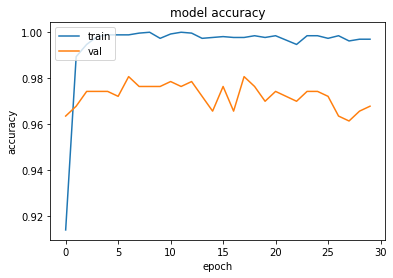

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

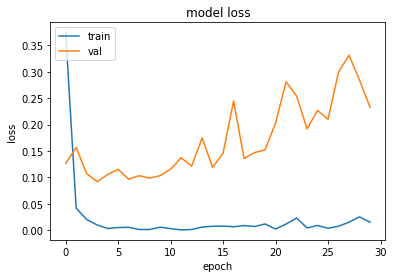

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
model.load_weights(checkpoint_filepath)

In [18]:
model.evaluate(X_test,y_test)

25/25 [==============================] - 1s 42ms/step - loss: 0.0751 - acc: 0.9833


[0.0751323327422142, 0.9832904934883118]

In [19]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)

print(classification_report(y_test, np.round(y_pred),digits=4))

13/13 [==============================] - 3s 49ms/step
              precision    recall  f1-score   support

           0     0.9839    0.9813    0.9826       374
           1     0.9827    0.9851    0.9839       404

    accuracy                         0.9833       778
   macro avg     0.9833    0.9832    0.9833       778
weighted avg     0.9833    0.9833    0.9833       778



In [20]:
print("accuracy_score",sklearn.metrics.accuracy_score(y_test, np.round(y_pred)))
print("f1_score",sklearn.metrics.f1_score(y_test, np.round(y_pred)))
print("precision_score",sklearn.metrics.precision_score(y_test, np.round(y_pred)))
print("recall_score",sklearn.metrics.recall_score(y_test, np.round(y_pred)))
print("roc_auc_score",sklearn.metrics.roc_auc_score(y_test, np.round(y_pred)))
print("specificity",sklearn.metrics.recall_score(y_test, np.round(y_pred),pos_label=0))

accuracy_score 0.9832904884318766
f1_score 0.9839307787391842
precision_score 0.9827160493827161
recall_score 0.9851485148514851
roc_auc_score 0.983215968655689
specificity 0.9812834224598931


In [22]:

last_conv_layer_name = "top_conv"

In [25]:
pretrained_model.get_layer(last_conv_layer_name)

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [27]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

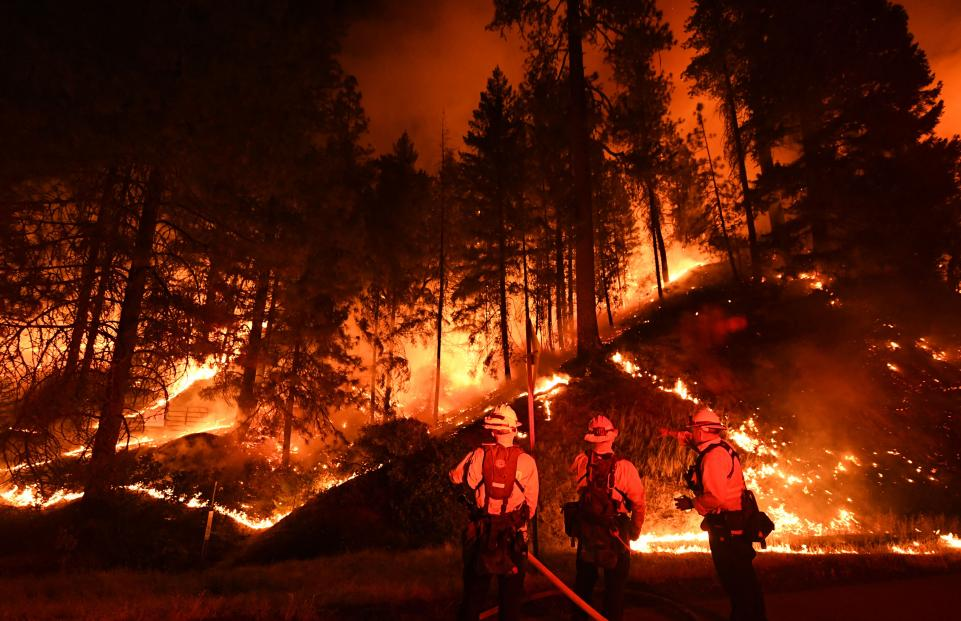

In [63]:
img_path = filepaths[0]
model = tf.keras.applications.EfficientNetB2(weights="imagenet")
img_size = (260,260)
preprocess_input = preprocess
display(Image(img_path))

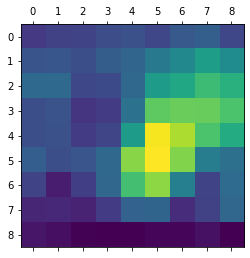

In [59]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))


# Remove last layer's softmax
model.layers[-1].activation = None


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

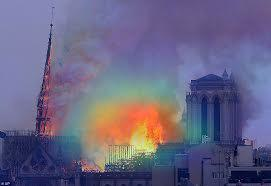

In [56]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)